# Categorical Variables Analysis

We will be examining the categorical variables of the `kaggle_steam` dataset (available in `data/01_raw/kaggle_steam.csv`) in this notebook.

After analysis, we will propose categorical features to adopt for our clustering model, KPrototypes.

The dataset has **12** categorical variables: `appid`, `name`, `release_date`, `english`, `developer`, `publisher`, `platforms`, `required_age`, `categories`, `genres`, `steamspy_tags` and `owners`.

We will be examining the following categorical variables to see if we can use them for clustering.

- `release_date`
- `english`
- `platforms`
- `required_age`
- `categories`
- `genres`
- `steamspy_tags`
- `owners`

We omitted:

- `app_id` as it is id value, it has no meaning,
- `name` is unique per record, hence has no meaning
- `developer` is immediately apparent to have many labels, it will increase dimensionality of our data too much and impact our model's performance
- `publisher` same as above

**Setting up**

In [114]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from sklearn.preprocessing import maxabs_scale, MultiLabelBinarizer

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

**All features of `kaggle_steam` and their dtypes**

The dataset has **12** categorical variables: `appid`, `name`, `release_date`, `english`, `developer`. `publisher`, `platforms`, `categories`, `genres`, `steamspy_tags` and `owners`.

In [116]:
kaggle_steam: pd.DataFrame = catalog.load('kaggle_steam')
kaggle_steam.dtypes.to_frame().T

[04/16/23 19:29:16] INFO     Loading data from 'kaggle_steam' (CSVDataSet)...                   ]8;id=806183;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528437;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,int64,object,object,int64,object,object,object,int64,object,object,object,int64,int64,int64,int64,int64,object,float64


# Dealing with single-valued categorical variables.

We will first look at `release_date`, `english`, `required_age`, and `owners` as each of them only contains a single value per record.

## [categorical.single/1] `release_date`

We observe that the dataset contains very few games from before 2014. The bulk of the data is from 2014 onwards. 

Since we have converted this column to numeric, it could be used because we can interpret that a game from 1997 is far from 2019 in the sense that times have changed.

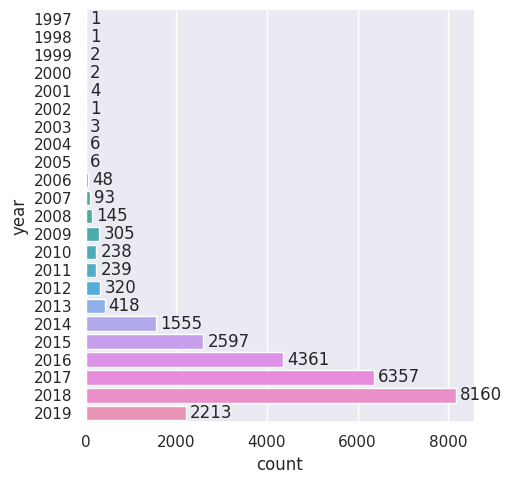

In [117]:
year = kaggle_steam['release_date'].str.split('-').map(lambda x: int(x[0]))
catplot_ylabel(sb.catplot(data=year.to_frame('year'), y='year', kind='count'))

## [categorical.single/2] `english`

It is immediately obvious that `english` is not a very good variable. Over `98%` of the data is `english` and thus it likely has limited effect on clustering.

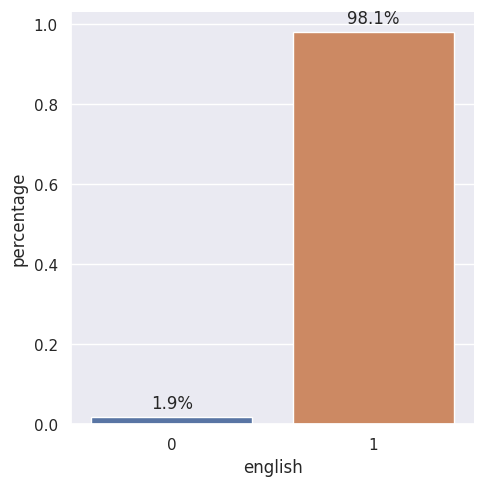

In [118]:
catplot_xpercent(data=kaggle_steam, var='english')

## [categorical.single/3] `required_age`

We decided to transform required_age into 2 one-hot features. 
1. mature (16,18)
2. kid-friendly (3,7,12)

0 seems to mean unrated which is the default for most games thus we think it is unlikely to help with clustering

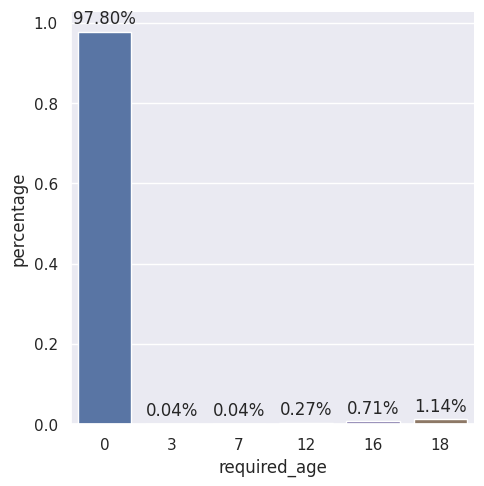

In [149]:
kid_friendly = ((kaggle_steam['required_age'] > 0) & (kaggle_steam['required_age'] <= 16)).astype(kaggle_steam['required_age'].dtype)
mature = (kaggle_steam['required_age'] >= 16).astype(kaggle_steam['required_age'].dtype)
catplot_xpercent(data=kaggle_steam, var='required_age', fmt='{0:.2%}')

## [categorical.single/4] `owners`

`owners` is a banded value.

We could keep it as categorical or possibly convert it to numeric since it appears somewhat continuous.

Available options:
- Retain the bands (categorical)
- log10 upper limit (numeric)
- MaxAbsScaler (numeric)
- StandardScaler (numeric)

Considerations:
1. `20K` and `200M` is extremely different. This would have a negative effect that `200M` observation would likely not be clustered together with a `20K` centroid even if it would be better to do so because the numeric difference is too huge.
2. Either the above or it affects the centroid it is a part of unnaturally causing other observations to be misclassified 
3. Require to reduce impact of `200M`. 
    - numerically: First we `log10` followed by `StandardScaler`.
    - categorically: retain the bands (one-hot encoding will introduce too many variables so we need to reband the values to keep it 3 or less)
4. While `MaxAbsScaler` reduces the negative effect on clustering, as it retains the difference in scale of `20K` and `200M` (4 orders of magnitude), it would make the difference between `20K`, `50K` and `100K` etc... seem negligible by comparison, while the difference between `100M` and `200M` becomes overemphasised. Therefore, it would not apply uniformly across the entire domain.

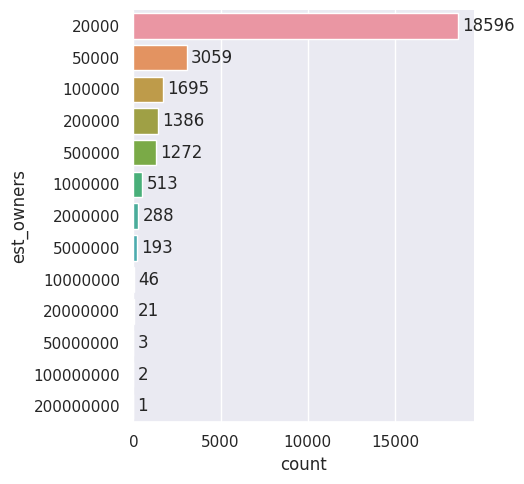

In [119]:
est_owners = kaggle_steam['owners'].str.split('-').map(lambda x: int(x[1]))

catplot_ylabel(sb.catplot(data=est_owners.to_frame('est_owners'), y='est_owners', kind='count'))

**Showing different approaches to scaling est_owners and their results**

In [153]:
from sklearn.preprocessing import maxabs_scale, scale
viz = est_owners.drop_duplicates().to_frame('est_owners').sort_values(by='est_owners').reset_index(drop=True)
viz['log10'] = viz['est_owners'].map(np.log10)
viz['maxabs'] = maxabs_scale(viz['est_owners'])
viz['log10_scale'] = pd.Series(scale(est_owners.map(np.log10).sort_values())).unique()
viz

,est_owners,log10,maxabs,log10_scale
0,20000,4.30103,0.00010,-0.544894
1,50000,4.69897,0.00025,0.219002
2,100000,5.00000,0.00050,0.796867
3,200000,5.30103,0.00100,1.374733
4,500000,5.69897,0.00250,2.138629
5,1000000,6.00000,0.00500,2.716494
6,2000000,6.30103,0.01000,3.294359
7,5000000,6.69897,0.02500,4.058255
8,10000000,7.00000,0.05000,4.636120
9,20000000,7.30103,0.10000,5.213985


With `log10_scale`, the rarity of `200M` games is also encoded in the values. We trade uniformity to achieve a balance in emphasis of the difference in `20K` and `200M`, instead of being overwhelmed by it.

In [154]:
viz.diff()

,est_owners,log10,maxabs,log10_scale
0,NaN,NaN,NaN,NaN
1,30000.0,0.39794,0.00015,0.763896
2,50000.0,0.30103,0.00025,0.577865
3,100000.0,0.30103,0.00050,0.577865
4,300000.0,0.39794,0.00150,0.763896
5,500000.0,0.30103,0.00250,0.577865
6,1000000.0,0.30103,0.00500,0.577865
7,3000000.0,0.39794,0.01500,0.763896
8,5000000.0,0.30103,0.02500,0.577865
9,10000000.0,0.30103,0.05000,0.577865


# Dealing with multi-valued categorical variables
These variables are `platforms`, `categories`, `genres`, `steamspy_tags`, with each value separated by a semicolon (;).

**Example of record with ;**

In [121]:
kaggle_steam[['platforms', 'categories', 'genres', 'steamspy_tags']].tail(1)

,platforms,categories,genres,steamspy_tags
27074,windows;mac,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure


**Helper method to split each value into its own column and one-hot encode it**

In [122]:
def describe_categorical_as_onehot(X: pd.Series, keep: "set[str] | 'all'" = 'all', sep=';'):
  df = pd.DataFrame(np.arange(0, len(X))).drop(labels=0, axis=1)
  mlb = MultiLabelBinarizer()
  x = mlb.fit_transform(X.str.split(sep)).T
  # print(f"Column `{X.name}` has {len(mlb.classes_)} unique labels\n\t{set(mlb.classes_)}")
  if keep is not None:
    for i, category in enumerate(mlb.classes_):
      if keep == 'all' or (category in keep):
        df[category] = x[i]
  return df

## [categorical.multi/1] `platforms`

`99.98%` of all games support windows, it is the most ubiquitous platform, so it is probably not the most useful.

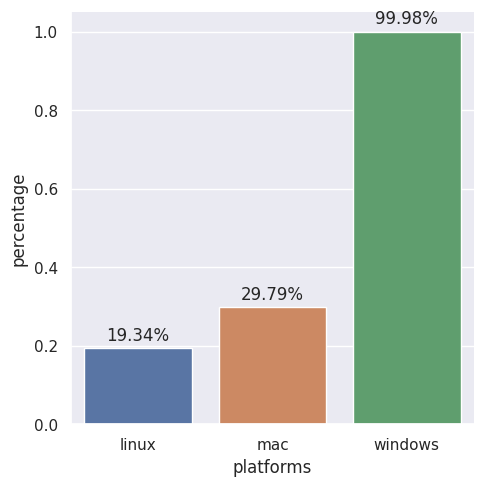

In [123]:
platforms = describe_categorical_as_onehot(kaggle_steam['platforms'])
catplot_xpercent_raw(data=platforms.sum() / len(platforms), var='platforms', fmt='{0:.2%}')

## [categorical.multi/2] `categories`

A lot of the labels appear to be associated with one another, for example `Multi-player` and similar labels such as `Co-op`, `Cross-platform Multiplayer`, etc. `Single-player` is also most likely not going to be useful due to `94.8%` of the dataset supporting solo play, so there is little variance.

About 50% of games have `2-4` categories while 95% of games have below `9` categories and 99% have below `11` categories.

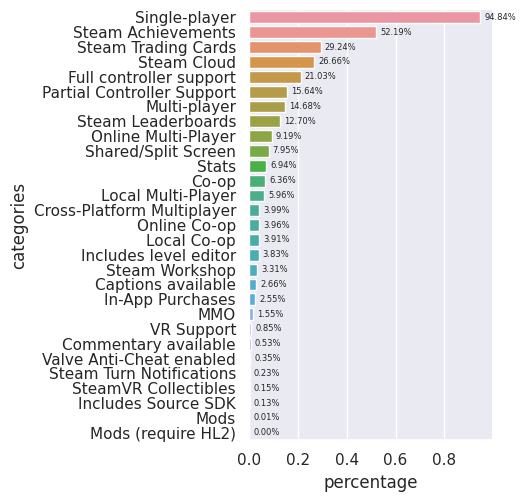

In [124]:
categories = describe_categorical_as_onehot(kaggle_steam['categories'])
with rc_context({'font.size': 6}):
    catplot_ypercent_raw(data=(categories.sum() / len(categories)).sort_values(ascending=False), var='categories', fmt='{0:.2%}')

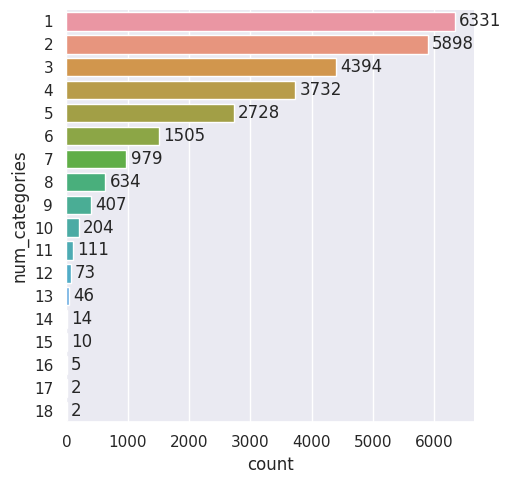

In [125]:
num_categories = kaggle_steam['categories'].str.split(';').map(len)
catplot_ylabel(sb.catplot(num_categories.to_frame('num_categories'), y='num_categories', kind='count'))

**Quantiles of num_categories**

In [126]:
num_categories.quantile([0.25,0.5,0.75,0.95,0.99]).to_frame('num_categories').T

,0.25,0.50,0.75,0.95,0.99
num_categories,2.0,3.0,4.0,8.0,10.0


<Axes: xlabel='num_categories'>

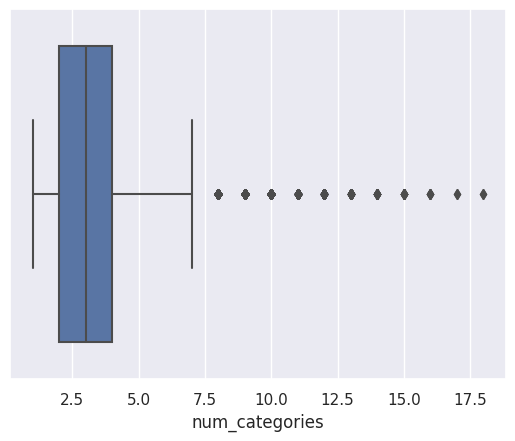

In [127]:
sb.boxplot(num_categories.to_frame('num_categories'), x='num_categories')

## [categorical.multi/3] `genres`

We see many labels for software instead of games in general like `Accounting`, `Animation & Modelling`, `Audio Production`, `Design & Illustration` etc. It might be possible for the clustering algorithm to identify software applications as a cluster. 

About 50% of games are classified under `2-4` genres while 95% are under `6` genres and 99% are under `8` genres.

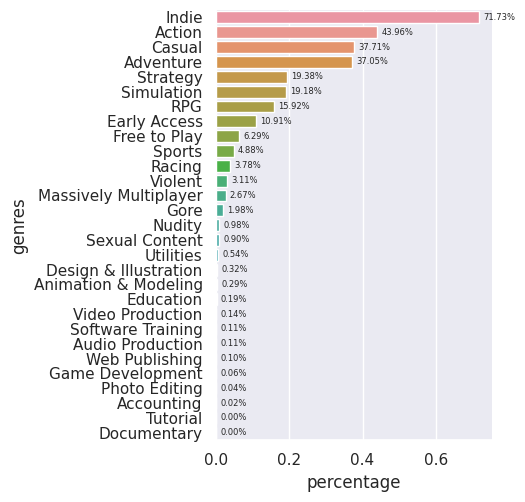

In [128]:
genres = describe_categorical_as_onehot(kaggle_steam['genres'])
with rc_context({'font.size': 6}):
    catplot_ypercent_raw(data=(genres.sum() / len(genres)).sort_values(ascending=False), var='genres', fmt='{0:.2%}')

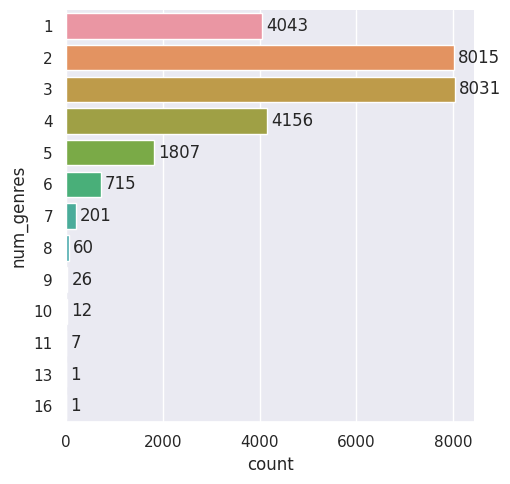

In [129]:
num_genres = kaggle_steam['genres'].str.split(';').map(len)
catplot_ylabel(sb.catplot(num_genres.to_frame('num_genres'), y='num_genres', kind='count'))

**Quantiles of num_genres**

In [130]:
num_genres.quantile([0.25,0.5,0.75,0.95,0.99]).to_frame('num_genres').T

,0.25,0.50,0.75,0.95,0.99
num_genres,2.0,3.0,4.0,5.0,7.0


<Axes: xlabel='num_genres'>

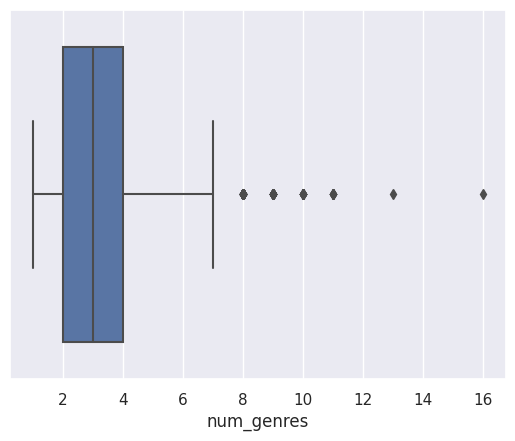

In [131]:
sb.boxplot(num_genres.to_frame('num_genres'), x='num_genres')

## [categorical.multi/4] `steamspy_tags`

There are 339 unique labels in `steamspy_tags`.

Most tags are very seldomly used/too specific such as `Intentionally Awkward Controls`. 75% of tags are only used by under 55 games. While specific tags can help carve out clusters, if they are only represented by a few games, it could mean that the label itself is not very widely-known/accepted as of yet. It could also just be a synonym for another tag. Hence we should be careful about which labels we decide to include. Since we want to carve out general clusters rather than specific clusters, we can most likely set a threshold to filter less popular tags.

Furthermore, some of these tags appear to be the same labels as `genres`.

With the reasons set out above, we feel that `steamspy_tags` is not worth it for clustering especially since clustering is gets more expensive with higher number of features.

Additionally, 90% of the games have exactly `3` steamspy_tags. The remaining 10% could potentially be helpful in finding clusters. However, this is unlikely since the overall quality of tags seem poor.

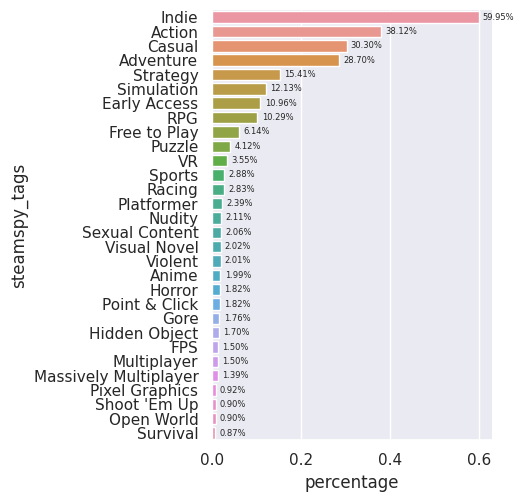

In [132]:
import warnings
warnings.filterwarnings('ignore')
tags = describe_categorical_as_onehot(kaggle_steam['steamspy_tags']).copy(deep=True) # this generates a lot of warnings
warnings.filterwarnings('default')

with rc_context({'font.size': 6}):
    catplot_ypercent_raw(data=(tags.sum() / len(tags)).nlargest(30), var='steamspy_tags', fmt='{0:.2%}')

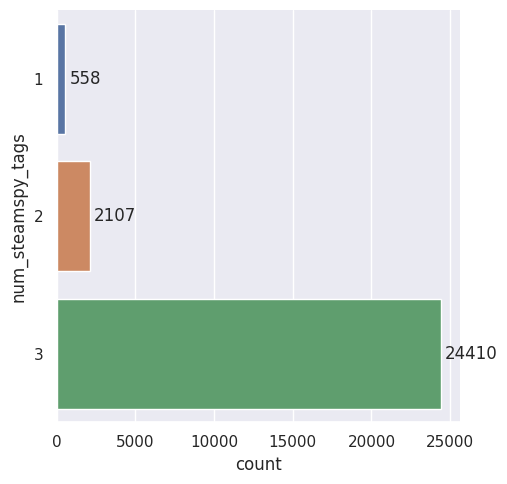

In [133]:
num_tags = kaggle_steam['steamspy_tags'].str.split(';').map(len)
catplot_ylabel(sb.catplot(num_tags.to_frame('num_steamspy_tags'), y='num_steamspy_tags', kind='count'))

**Proof that under 75% of `steamspy_tags` are only used by <=55 games**

In [134]:
tags.sum().describe()

count      339.000000
mean       230.094395
std       1258.224753
min          1.000000
25%          4.000000
50%         14.000000
75%         55.000000
max      16232.000000
dtype: float64

# Summary

- Pearson's correlation coefficient cannot be used for categorical data. (association, chi-squared?)
- PCA cannot be used for categorical data. (MCA, MFA)
- K-means cannot be used for categorical data. (k-modes, k-prototype)

In [155]:
keep = pd.concat([
    kaggle_steam['appid'].to_frame(), 
    year.to_frame('year'), 
    est_owners.to_frame('est_owners'),
    num_categories.to_frame('num_categories'),
    num_genres.to_frame('num_genres'),
    # num_tags.to_frame('num_steamspy_tags'),
    # kaggle_steam['english'].to_frame(), 
    kid_friendly.to_frame('kid_friendly'),
    mature.to_frame('mature'),
    platforms[['mac', 'linux']], 
    categories[['Multi-player', 'Steam Achievements', 'Steam Trading Cards']], 
    genres[['Indie', 'Action', 'Casual', 'Strategy', 'Simulation', 'Free to Play']],
], axis=1)

catalog.save('features_eng_1', keep)

[04/17/23 20:48:53] INFO     Saving data to 'features_eng_1' (CSVDataSet)...                    ]8;id=243812;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=98729;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#382\382]8;;\

In [156]:
keep.columns

Index(['appid', 'year', 'est_owners', 'num_categories', 'num_genres',
       'kid_friendly', 'mature', 'mac', 'linux', 'Multi-player',
       'Steam Achievements', 'Steam Trading Cards', 'Indie', 'Action',
       'Casual', 'Strategy', 'Simulation', 'Free to Play'],
      dtype='object')